In [10]:
# ============================================================
# SUPER SIMPLE TIME SERIES ANALYSIS
# Using "Sample - Superstore.csv"
#
# What this script does:
#   1. Reads the CSV file
#   2. Makes a time series of Sales by Order Date
#   3. Aggregates to MONTHLY sales (easier to read)
#   4. Decomposes into: Trend, Seasonality, Noise + Cyclicality
#   5. Runs ADF test for stationarity
#   6. Splits data into Train and Test
#   7. Fits a simple ARIMA model and makes a forecast
#   8. Plots Actual vs Forecast and prints error metrics
# ============================================================

In [11]:
#from google.colab import files      # For uploading/downloading files in Google Colab
#print("Please upload your csv file")
#uploaded = files.upload()  # Opens a file upload dialog box in Google Colab

In [12]:


# ---- IMPORT LIBRARIES ----
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# For decomposition and ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# For forecast accuracy
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [13]:
# ============================================================
# STEP 1: LOAD THE DATA
# ============================================================

# Read the CSV file
# Make sure "Sample - Superstore.csv" is in the same folder as your notebook.
df = pd.read_csv("Sample - Superstore.csv")

In [14]:

# Convert Order Date to actual date type (very important for time series)
df["Order Date"] = pd.to_datetime(df["Order Date"])

# Sort the data by date (oldest to newest)
df = df.sort_values("Order Date")

print("Data loaded. First few rows:")
print(df.head())

Data loaded. First few rows:
      Row ID        Order ID Order Date   Ship Date       Ship Mode  \
7980    7981  CA-2014-103800 2014-01-03  2014-01-07  Standard Class   
739      740  CA-2014-112326 2014-01-04  2014-01-08  Standard Class   
740      741  CA-2014-112326 2014-01-04  2014-01-08  Standard Class   
741      742  CA-2014-112326 2014-01-04  2014-01-08  Standard Class   
1759    1760  CA-2014-141817 2014-01-05  2014-01-12  Standard Class   

     Customer ID  Customer Name      Segment        Country          City  \
7980    DP-13000  Darren Powers     Consumer  United States       Houston   
739     PO-19195  Phillina Ober  Home Office  United States    Naperville   
740     PO-19195  Phillina Ober  Home Office  United States    Naperville   
741     PO-19195  Phillina Ober  Home Office  United States    Naperville   
1759    MB-18085     Mick Brown     Consumer  United States  Philadelphia   

      ... Postal Code   Region       Product ID         Category Sub-Category  \


In [15]:

# ============================================================
# STEP 2: BUILD DAILY AND MONTHLY SALES TIME SERIES
# ============================================================

# Group by Order Date and sum Sales for each day
daily_sales = (
    df.groupby("Order Date")["Sales"]
    .sum()
)

# Make sure the index is a DateTimeIndex and has all days in between
# .asfreq("D") will create rows for missing days
daily_sales = daily_sales.asfreq("D")

# If some days are missing sales, we set them to 0
daily_sales = daily_sales.fillna(0)

print("\nDaily sales time series (first few rows):")
print(daily_sales.head())


Daily sales time series (first few rows):
Order Date
2014-01-03      16.448
2014-01-04     288.060
2014-01-05      19.536
2014-01-06    4407.100
2014-01-07      87.158
Freq: D, Name: Sales, dtype: float64


In [16]:


# Daily data can be noisy. For teaching and ARIMA, monthly is easier.
# So we aggregate (resample) daily_sales to MONTHLY totals.
monthly_sales = daily_sales.resample("M").sum()
monthly_sales.name = "Sales"

print("\nMonthly sales time series (first few rows):")
print(monthly_sales.head())



Monthly sales time series (first few rows):
Order Date
2014-01-31    14236.895
2014-02-28     4519.892
2014-03-31    55691.009
2014-04-30    28295.345
2014-05-31    23648.287
Freq: ME, Name: Sales, dtype: float64


C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_5992\744431784.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = daily_sales.resample("M").sum()


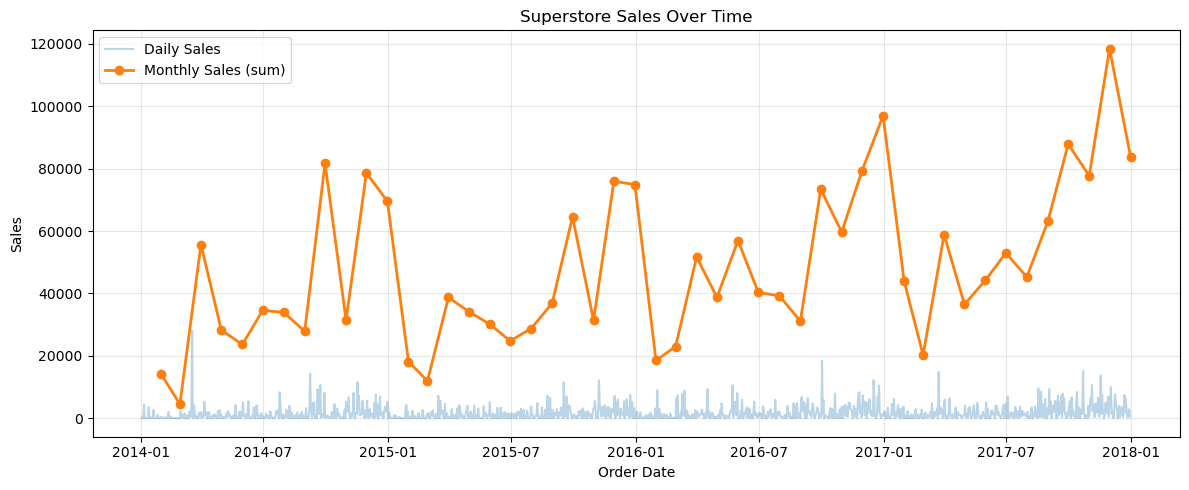

In [17]:


# ============================================================
# STEP 3: PLOT DAILY VS. MONTHLY SALES (CONTEXT)
# ============================================================

plt.figure(figsize=(12, 5))

# Plot daily sales with low opacity (faded) so it doesn't look too messy
plt.plot(daily_sales.index, daily_sales, alpha=0.3, label="Daily Sales")

# Plot monthly sales with markers and a thicker line
plt.plot(monthly_sales.index, monthly_sales, marker="o", linewidth=2,
         label="Monthly Sales (sum)")

plt.title("Superstore Sales Over Time")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

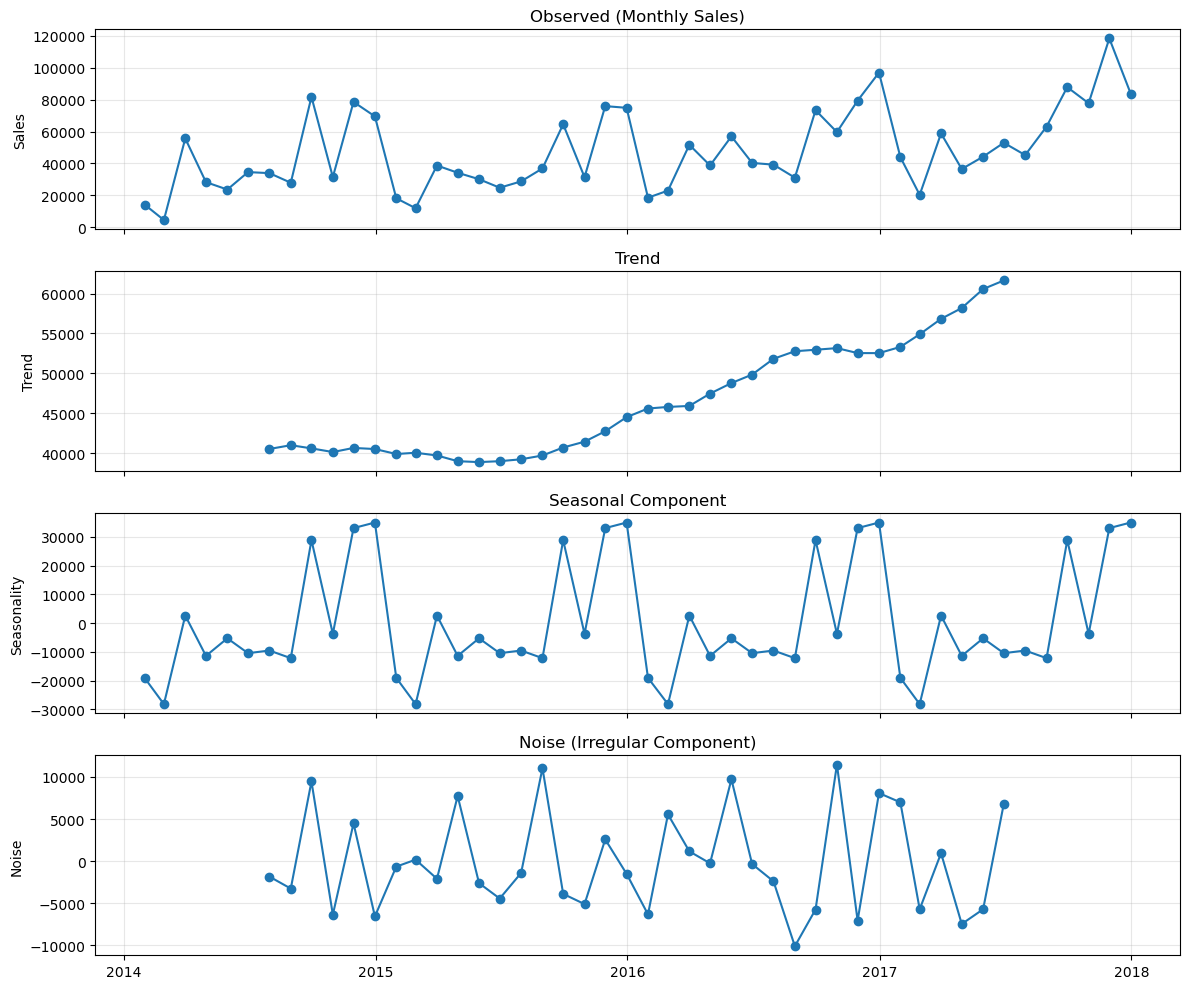

In [18]:

# ============================================================
# STEP 4: DECOMPOSE MONTHLY SALES
# Into: Trend, Seasonality, Residuals, plus Cyclicality
# ============================================================

# We assume yearly seasonality (period = 12 months)
decomp = seasonal_decompose(monthly_sales, model="additive", period=12)

trend = decomp.trend       # long-term direction of the series
seasonal = decomp.seasonal # repeating pattern within each year
resid = decomp.resid       # leftover after removing trend + seasonality

# ---- CYCLICALITY ----
# "Cyclicality" is slower, long-term ups and downs that are not fixed-length like seasonality.
# Here we approximate it by taking a rolling (moving) average of the residuals.
# This smooths the residuals so we see gentle cycles instead of random noise.
cycle = resid.rolling(window=6, center=True, min_periods=3).mean()

# Whatever is left after removing this "cycle" from residuals we call "noise"
noise = resid - cycle

# ---- Plot the decomposition: Observed, Trend, Seasonality, Noise ----
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(monthly_sales.index, monthly_sales, marker="o")
axes[0].set_title("Observed (Monthly Sales)")
axes[0].set_ylabel("Sales")
axes[0].grid(True, alpha=0.3)

axes[1].plot(trend.index, trend, marker="o")
axes[1].set_title("Trend")
axes[1].set_ylabel("Trend")
axes[1].grid(True, alpha=0.3)

axes[2].plot(seasonal.index, seasonal, marker="o")
axes[2].set_title("Seasonal Component")
axes[2].set_ylabel("Seasonality")
axes[2].grid(True, alpha=0.3)

axes[3].plot(noise.index, noise, marker="o")
axes[3].set_title("Noise (Irregular Component)")
axes[3].set_ylabel("Noise")
axes[3].grid(True, alpha=0.3)

# Make x-axis show years to avoid clutter
axes[3].xaxis.set_major_locator(mdates.YearLocator())
axes[3].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()

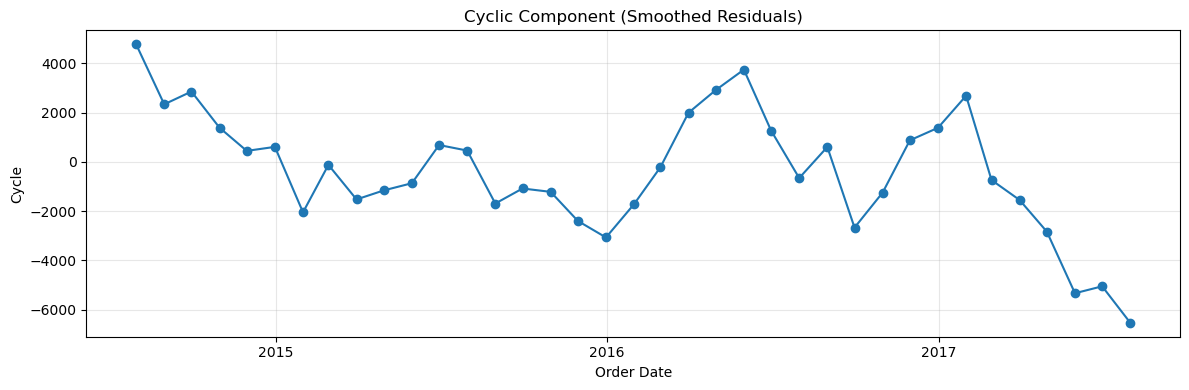

In [21]:
# ---- Plot Cyclicality separately ----
plt.figure(figsize=(12, 4))
plt.plot(cycle.index, cycle, marker="o")
plt.title("Cyclic Component (Smoothed Residuals)")
plt.xlabel("Order Date")
plt.ylabel("Cycle")
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()

In [22]:


# ============================================================
# STEP 5: ADF (AUGMENTED DICKEY-FULLER) TEST FOR STATIONARITY
# ============================================================
# Stationarity = mean, variance, and patterns don't change over time.
# ARIMA likes stationary data.


def run_adf_test(series, title):
    """
    Runs the ADF test and prints a very simple interpretation.
    """
    print("\n" + "="*50)
    print(title)
    print("="*50)

    # Drop missing values to avoid errors
    series = series.dropna()

    # adfuller() returns several things; we only care about a few
    result = adfuller(series)

    adf_stat = result[0]       # test statistic
    p_value = result[1]        # p-value
    used_lags = result[2]      # how many lags were used
    n_obs = result[3]          # number of observations used
    critical_values = result[4]# critical values at 1%, 5%, 10%

    print(f"ADF Statistic : {adf_stat}")
    print(f"p-value       : {p_value}")
    print(f"# Lags Used   : {used_lags}")
    print(f"# Observations: {n_obs}")

    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")

    # Simple conclusion for beginners
    if p_value <= 0.05:
        print("Conclusion: p-value <= 0.05, reject H0 → Series is LIKELY STATIONARY.")
    else:
        print("Conclusion: p-value > 0.05, fail to reject H0 → Series is LIKELY NON-STATIONARY.")


# ADF test on original monthly sales
run_adf_test(monthly_sales, "ADF Test on ORIGINAL Monthly Sales")

# ADF test on first difference (usually makes it more stationary)
diff_monthly_sales = monthly_sales.diff()
run_adf_test(diff_monthly_sales, "ADF Test on FIRST-DIFFERENCED Monthly Sales")


ADF Test on ORIGINAL Monthly Sales
ADF Statistic : -4.493767844002666
p-value       : 0.00020180198458237704
# Lags Used   : 0
# Observations: 47
Critical Values:
   1%: -3.5778480370438146
   5%: -2.925338105429433
   10%: -2.6007735310095064
Conclusion: p-value <= 0.05, reject H0 → Series is LIKELY STATIONARY.

ADF Test on FIRST-DIFFERENCED Monthly Sales
ADF Statistic : -9.057696814194
p-value       : 4.653163912897031e-15
# Lags Used   : 10
# Observations: 36
Critical Values:
   1%: -3.626651907578875
   5%: -2.9459512825788754
   10%: -2.6116707716049383
Conclusion: p-value <= 0.05, reject H0 → Series is LIKELY STATIONARY.



Train period: 2014-01-31 00:00:00 to 2016-12-31 00:00:00
Test period : 2017-01-31 00:00:00 to 2017-12-31 00:00:00
Train size: 36  | Test size: 12


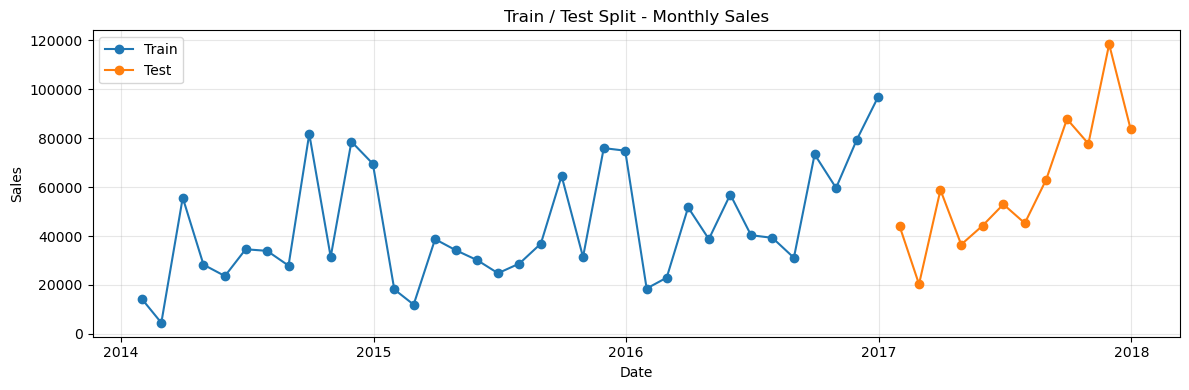

In [23]:
# ============================================================
# STEP 6: TRAIN / TEST SPLIT
# ============================================================
# We keep the last 12 months as TEST data
# Everything before that is TRAIN data

test_size = 12  # months
train = monthly_sales.iloc[:-test_size]
test = monthly_sales.iloc[-test_size:]

print("\nTrain period:", train.index.min(), "to", train.index.max())
print("Test period :", test.index.min(), "to", test.index.max())
print("Train size:", len(train), " | Test size:", len(test))

# Plot to show which part is train and which is test
plt.figure(figsize=(12, 4))
plt.plot(train.index, train, marker="o", label="Train")
plt.plot(test.index, test, marker="o", label="Test")
plt.title("Train / Test Split - Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()

In [24]:



# ============================================================
# STEP 7: FIT A SIMPLE ARIMA MODEL
# ============================================================
# ARIMA has 3 numbers: (p, d, q)
#   p = AR (Auto-Regressive) order
#   d = differencing order (how many times we take differences)
#   q = MA (Moving Average) order
#
# For simplicity, we just choose ARIMA(1, 1, 1).
# In real life, we would tune these numbers.

model_order = (1, 1, 1)  # (p, d, q)

print(f"\nFitting ARIMA{model_order} model on TRAIN data...")

# Create ARIMA model using only TRAIN data
arima_model = ARIMA(train, order=model_order)

# Fit the model (this estimates the parameters)
arima_result = arima_model.fit()

# Print a short summary
print("\nModel fitted. Summary (you can ignore the details if it's too much):")
print(arima_result.summary())


Fitting ARIMA(1, 1, 1) model on TRAIN data...

Model fitted. Summary (you can ignore the details if it's too much):
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -401.805
Date:                Tue, 18 Nov 2025   AIC                            809.610
Time:                        18:19:45   BIC                            814.276
Sample:                    01-31-2014   HQIC                           811.220
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1072      0.281      0.382      0.703      -0.443       0.658
ma.L1         

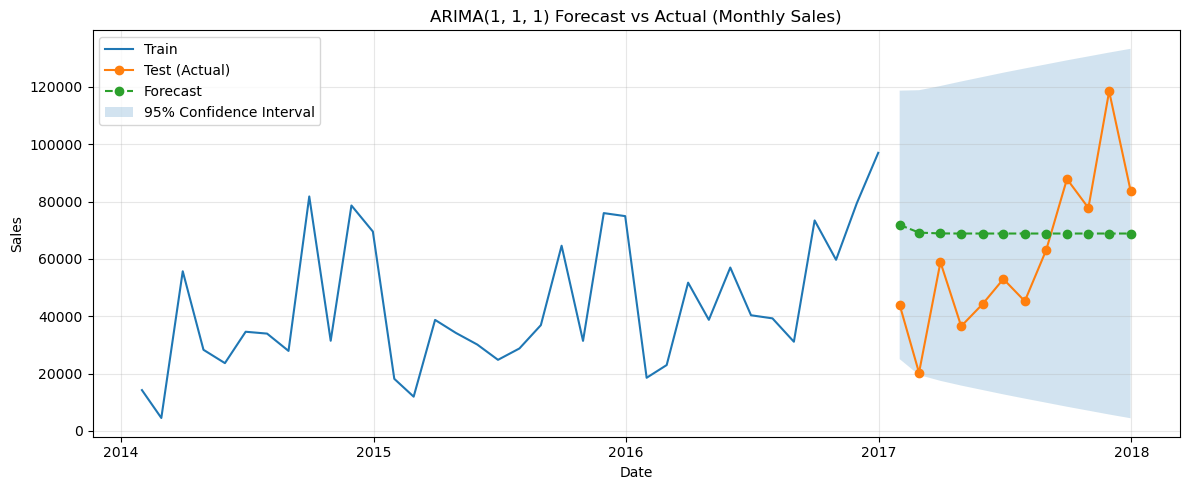

In [25]:

# ============================================================
# STEP 8: FORECAST ON TEST PERIOD AND PLOT RESULTS
# ============================================================

# We want forecasts for the same number of months as the test set
n_test = len(test)

# Get forecast for next n_test months
forecast_obj = arima_result.get_forecast(steps=n_test)

# Predicted values (the actual forecast)
forecast_mean = forecast_obj.predicted_mean

# Confidence interval (range where model expects the true value to fall)
forecast_ci = forecast_obj.conf_int()

# Make sure forecast has same index as test (same dates)
forecast_mean.index = test.index
forecast_ci.index = test.index

# ---- Plot actual vs forecast ----
plt.figure(figsize=(12, 5))

# Training data
plt.plot(train.index, train, label="Train")

# Actual values in test period
plt.plot(test.index, test, marker="o", label="Test (Actual)")

# Forecasted values
plt.plot(forecast_mean.index, forecast_mean, marker="o", linestyle="--",
         label="Forecast")

# Confidence interval as shaded area
plt.fill_between(
    forecast_ci.index,
    forecast_ci["lower Sales"],
    forecast_ci["upper Sales"],
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title(f"ARIMA{model_order} Forecast vs Actual (Monthly Sales)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()

In [26]:
# ============================================================
# STEP 9: FORECAST ACCURACY (HOW GOOD IS THE MODEL?)
# ============================================================

# RMSE (Root Mean Squared Error) – kind of like "average" error size
rmse = sqrt(mean_squared_error(test, forecast_mean))

# MAE (Mean Absolute Error) – average of absolute errors
mae = mean_absolute_error(test, forecast_mean)

print("\nForecast Accuracy on TEST set:")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")

print("\nInterpretation:")
print("- Lower RMSE and MAE are better.")
print("- Compare errors to typical sales volume to judge if the model is 'good enough'.")



Forecast Accuracy on TEST set:
RMSE: 27,208.45
MAE : 23,450.63

Interpretation:
- Lower RMSE and MAE are better.
- Compare errors to typical sales volume to judge if the model is 'good enough'.


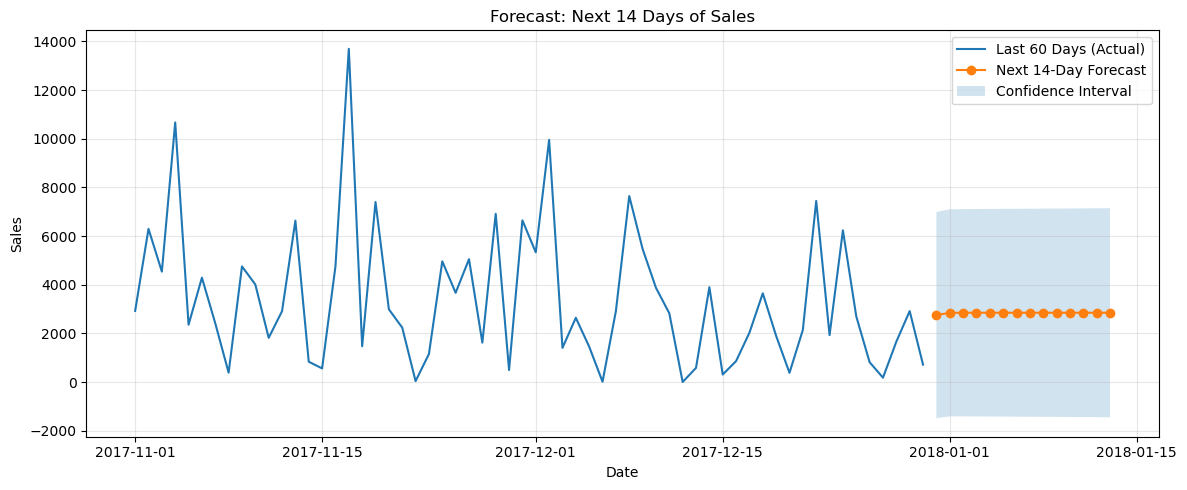

In [29]:
# ============================================================
# EXTRA FORECASTS: 14 DAYS AND NEXT QUARTER
# ============================================================

# ------------------------------------------------------------
# PART A: FORECAST NEXT 14 DAYS (DAILY FORECAST)
# ------------------------------------------------------------
# We use daily_sales (already created earlier)
# First, fit ARIMA on DAILY sales instead of monthly

daily_model = ARIMA(daily_sales, order=(1,1,1))
daily_result = daily_model.fit()

# Forecast for next 14 days
n_days = 14
daily_forecast_obj = daily_result.get_forecast(steps=n_days)

daily_forecast = daily_forecast_obj.predicted_mean
daily_ci = daily_forecast_obj.conf_int()

# Create new date index for next 14 days
future_daily_index = pd.date_range(
    start=daily_sales.index[-1] + pd.Timedelta(days=1),
    periods=n_days,
    freq="D"
)

daily_forecast.index = future_daily_index
daily_ci.index = future_daily_index

# ------- Plot next 14 days forecast -------
plt.figure(figsize=(12,5))
plt.plot(daily_sales.index[-60:], daily_sales[-60:], label="Last 60 Days (Actual)")
plt.plot(daily_forecast.index, daily_forecast, marker="o", label="Next 14-Day Forecast")
plt.fill_between(daily_ci.index,
                 daily_ci.iloc[:,0], daily_ci.iloc[:,1],
                 alpha=0.2, label="Confidence Interval")

plt.title("Forecast: Next 14 Days of Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_5992\1817915674.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_month_index = pd.date_range(


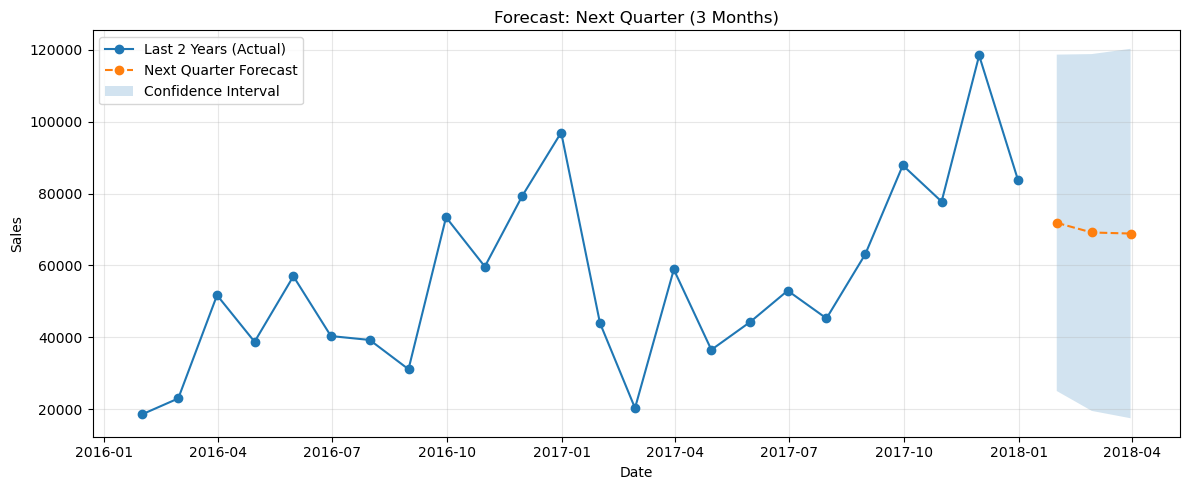


Next 14-Day Forecast:
2017-12-31    2752.054763
2018-01-01    2843.705967
2018-01-02    2847.827092
2018-01-03    2848.012400
2018-01-04    2848.020732
2018-01-05    2848.021107
2018-01-06    2848.021123
2018-01-07    2848.021124
2018-01-08    2848.021124
2018-01-09    2848.021124
2018-01-10    2848.021124
2018-01-11    2848.021124
2018-01-12    2848.021124
2018-01-13    2848.021124
Freq: D, Name: predicted_mean, dtype: float64

Next Quarter (3-Month) Forecast:
2018-01-31    71868.645462
2018-02-28    69173.742644
2018-03-31    68884.749954
Freq: ME, Name: predicted_mean, dtype: float64


In [30]:

# ------------------------------------------------------------
# PART B: FORECAST NEXT QUARTER (NEXT 3 MONTHS)
# ------------------------------------------------------------
# Use the ARIMA model already trained on MONTHLY data: arima_result

n_months = 3  # 3 months = next quarter
quarter_forecast_obj = arima_result.get_forecast(steps=n_months)

quarter_forecast = quarter_forecast_obj.predicted_mean
quarter_ci = quarter_forecast_obj.conf_int()

# Generate future month-end dates
future_month_index = pd.date_range(
    start=monthly_sales.index[-1] + pd.offsets.MonthEnd(),
    periods=n_months,
    freq="M"
)

quarter_forecast.index = future_month_index
quarter_ci.index = future_month_index

# ------- Plot next quarter forecast -------
plt.figure(figsize=(12,5))
plt.plot(monthly_sales.index[-24:], monthly_sales[-24:], marker="o", label="Last 2 Years (Actual)")
plt.plot(quarter_forecast.index, quarter_forecast, marker="o", linestyle="--", label="Next Quarter Forecast")
plt.fill_between(quarter_ci.index,
                 quarter_ci.iloc[:,0], quarter_ci.iloc[:,1],
                 alpha=0.2, label="Confidence Interval")

plt.title("Forecast: Next Quarter (3 Months)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNext 14-Day Forecast:")
print(daily_forecast)

print("\nNext Quarter (3-Month) Forecast:")
print(quarter_forecast)
